# Ichimoku Kinko Hyo Indicator Analysis for Equities
## Author: Don Tran

#### Note: I structured this writeup to emphasize more on the thought process of my approach. The bases of this is to show how to gather, visualize, and analyze stock data. 

#### There are countless other indicators out there that are more commonly used, but for this project, I decided to use the Ichimoku Kinko Hyo Indicator.

#### Disclaimers: The purpose of the information here is to share my ideas and techniques. This should not be interpreted as professional advice. Please understand the risks invoved if you decide to implement this or any other techniques in your investment strategy.

#### Ichimoku kinko hyo is a technical indicator that was developed to identify momentum in the market, trends, market baise, and can also be used to define support and resistance levels. The idea is identify entry and exit signals in a trending market. In general this indicator is best used when there is  momentum in the market, for times where there is little momentum and is consolidating, other indicators are better suited. 

#### This indicator has 5 components where the mathematics is taking midpoint of 2 numbers with exception to one of the components. The difference between the components is that the calculation is done over different time periods and is shifted back 26 periods, remain unshifted, or moves ahead 26 periods. I’ll explain more in detail later in this project.

#### First thing to do is to get the stock information. I chose to use Google finance which is the best option for this particular project. Other options require an additional premium, but personally, I think Google finance is just fine in terms of quality and response time. Yahoo finance is another good alternative to Google finance. The response time is slower and the smallest time interval is daily. Google finance allows you to get minute data but the difference is that Yahoo finance allows you to get historic data where Google finance restricts you to 15 days from the date of your request.

In [1]:
import urllib
import time
import csv
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import requests
from shapely.geometry import LineString
%matplotlib inline

def get_data(SYM, Interval, Duration):
    url = 'http://www.google.com/finance/getprices?q={0}'.format(SYM.upper())
    url += "&i={0}&p={1}d&f=d,o,h,l,c,v".format(Interval, Duration)

    # Get Request
    response = requests.get(url).text.split()

    # Remove header
    response = [line.split(',') for line in response[7:]]

    # Save to Dataframe
    stocks = pd.DataFrame(response, columns=['Datetime','Close','High','Low','Open','Volume'])

    # Convert to Datetime
    stocks['Datetime'] = stocks['Datetime'].apply(lambda x: datetime.fromtimestamp(int(x[1:])))

    return stocks

#### The following function requires 3 arguments. 

#### Interval - how long you want the time periods to be in seconds
#### SYM - the stock symbol
#### Duration - amount of days from the time you send the request

#### The function sends the request then structure and store the information into a dataframe after removing the header. The Datetime column returned series of UNIX format numbers which had to be converted to Datetime format. 

#### There was an offset with the Datetime, it turned out that adding 1 to the UNIX number corrected the offset.

In [2]:
Interval = 60
SYM = 'SWN'
Duration = 5

stocks = get_data(SYM, Interval+1, Duration)
stocks.head()

,Datetime,Close,High,Low,Open,Volume
0,2016-05-18 09:30:00,12.04,12.09,12.04,12.09,70538
1,2016-05-18 09:31:00,12.21,12.2224,12.01,12.01,52940
2,2016-05-18 09:32:00,12.18,12.24,12.14,12.22,33192
3,2016-05-18 09:33:00,12.26,12.26,12.17,12.17,26280
4,2016-05-18 09:34:00,12.43,12.43,12.24,12.25,55606


#### Now that we have have the data, we now need to calculate the components of our indicator.

#### The components of the Inchimoku indicator are:

#### Tankan-Sen, Kijun-Sen, Chikou Span, Senkou Span A, and Senkou Span B

#### The Tankan-Sen, Kijun-Sen, and Senkou Span B is just taking the highest closing price and lowest closing price then dividing by 2. The difference is that the Tankan-Sen is over the last 9 time periods while the Kijun-Sen is over the last 26 time periods and Senkou Span B is over the last 52 time periods. Tenkan-Sen and Kijun-Sen is not shifted any periods, but senkou span B is shifted 26 time periods ahead on the graph. Senkou Span A is the the sum of the Tankan-Sen and Kijun-Sen divided by two. Senkou Span A is shifted 26 time periods ahead as well. The Chikou Span is the closing price shifted 26 time periods back.


#### So in summary:

### Tankan-Sen
- (Highest closing price + lowest closing price) / 2
- calculated over the last 9 periods
- Not shifted

### Kijun-Sen
- (Highest closing price + lowest closing price) / 2
- calculated over the last 26 periods
- Not shifted

### Chikou Span
- Closing price
- Shifted 26 periods back

### Senkou Span A
- (Tenhansen + kijunsen) / 2
- Shifted 26 periods ahead

### Senkou Span B
- (Highest closing price + lowest closing price) / 2
- calculated over the last 52 periods
- Shifted 26 periods ahead

In [3]:
high_prices = stocks['High']
close_prices = stocks['Close']
low_prices = stocks['Low']

# Tenkan-sen
nine_period_high = pd.rolling_max(high_prices, window=9)
nine_period_low = pd.rolling_min(low_prices, window=9)
stocks['tenkan_sen'] = (nine_period_high + nine_period_low) / 2

# Kijun-sen
twenty_six_period_high = pd.rolling_max(high_prices, window=26)
twenty_six_period_low = pd.rolling_min(low_prices, window=26)
stocks['kijun_sen'] = (twenty_six_period_high + twenty_six_period_low) / 2

#Chikou Span
stocks['chikou_span'] = close_prices.shift(-26)

# Senkou Span A
senkou_span_a = ((stocks['tenkan_sen'] + stocks['kijun_sen']) / 2).shift(26)
stocks['senkou_span_a'] = senkou_span_a

# Senkou Span B
fifty_two_period_high = pd.rolling_max(high_prices, window=52)
fifty_two_period_low = pd.rolling_min(low_prices, window=52)
stocks['senkou_span_b'] = ((fifty_two_period_high + fifty_two_period_low) / 2).shift(26)


/Users/Don/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=9,center=False).max()
/Users/Don/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=9,center=False).min()
/Users/Don/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).max()
/Users/Don/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).min()
/Users/Don/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarn

#### Since 3 of our components require shifting either forwards or backwards, it will store values that are out of index and null values around the first and last few rows. The simplest thing to do is to just only use the data in the middle rows and toss out the data that contains the errors. So for this project, I selected the duration to be 5 days, only data from the 3rd day would be used.


In [4]:
stock_split = np.array_split(stocks, Duration)

stock = stock_split[2]

#### Now using matplotlib to visualize the data. The x axis is label by the index number. So for an interval of 60 seconds, the highest index number would be 390 and each increment of 1 equals 60 seconds. (6.5 hours in a trading day which is equivalent to 390 minutes).

#### How to read the ichimoku chart:
#### Senkou span A and B forms the kumo cloud which is often used to define support and resistance levels. The thickness of the cloud shows the strength of the support or resistance.

#### Tankansen and Kijunsen can be used as signals for when a trend begins and ends. If these lines cross with the Tankansen above the kijunsen, it would be a signal that a potential upward trend will form. When the kijunsen crosses above the tankansen would be a signal that a downwards trend could possibly form. So these crosses are good entry and exit signals.

#### The chikouspan indicates momentum in the market. A way to think about it is that it that the chikouspan is just the closing price shifted back 26 periods. If you see that current prices the same as 26 periods ago, there is little movement in price. So if there is a tankansen and kijunsen cross, you would want the chikou span to be above or below the price. If the chikou span is within price, then it is consolidating.

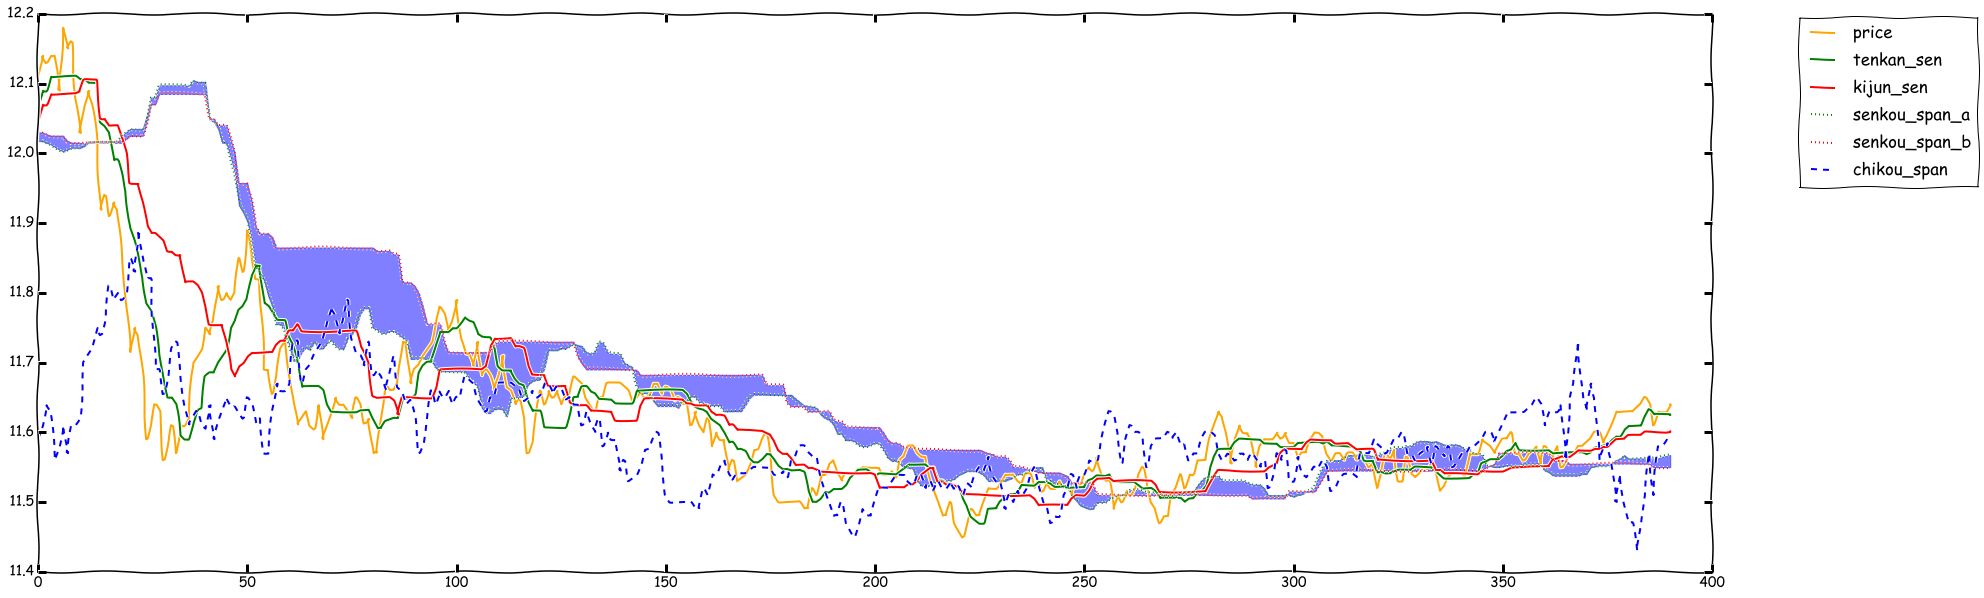

In [5]:
#Made the graph look like an xkcd comic just to make it look cool. Comment out plt.xkcd() 
#if you are uncool and don't like cool looking graphs.
plt.xkcd()

plt.figure(figsize=(30,10))
stock['Close'] = stock['Close'].astype(float)
stock['High'] = stock['High'].astype(float)
stock['Low'] = stock['Low'].astype(float)
stock['Open'] = stock['Open'].astype(float)
stock['Volume'] = stock['Volume'].astype(float)
stock['tenkan_sen'] = stock['tenkan_sen'].astype(float)
stock['kijun_sen'] = stock['kijun_sen'].astype(float)
stock['senkou_span_a'] = stock['senkou_span_a'].astype(float)
stock['senkou_span_b'] = stock['senkou_span_b'].astype(float)
stock['chikou_span'] = stock['chikou_span'].astype(float)
x = np.arange(stock['Datetime'].count())

plt.plot(x, stock['Close'],color='orange', label="price")
plt.plot(x, stock['tenkan_sen'],color='green')
plt.plot(x, stock['kijun_sen'],color='red')
plt.plot(x, stock['senkou_span_a'], 'k:',color='green')
plt.plot(x, stock['senkou_span_b'], 'k:', color='red')
plt.plot(x, stock['chikou_span'],'r--',color='blue')
opens = stock['Open']
highs = highs = stock['High']
lows = stock['Low']
closes = stock['Close']

#Create Kumo Cloud
plt.fill_between(x, stock['senkou_span_a'], stock['senkou_span_b'], color='blue', alpha='.5')

#Uncomment if you want the Datetime rather than the index number for the x axis label
#plt.xticks(x, stock['Datetime'], rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show()

#### This project is a good start for building an automatic/semi-automatic approach. For instance, if you wanted to train a machine learning model that classify if a tenkensan and kijunsen cross is a good entry signal, you would have to build a dataset of points where they cross, information about  other features that determines a good entry signal such as where the chikou span price was at during the cross, then you have to classify if each row given the information is a good entry signal or not. From there, you can train your model on dataset you built.

#### Additional information: Although other indicators were not not discusses, they can be incorperated to build a more robust model. For example, buy and sell signals in the ichimoku kinko hyo indicator would be the tenkensen and kijunsen cross. Other indicators such as MACD uses moving averages rather than the median of a range of values.

#### Here is a list of common indicators and how they are used to measure the features of stock prices.
- William %R, RSI, CCI, and MACD indicators are commonly used for buy and sell signals. (William %R is more often used for short term momentum and for indentifying overbought and oversold statuses)
- ADX (Often used with DMI) and MFI are used for trend discovery
- ATR is used for volatility signals
- OBV is used for volume weights

#### Note: Stock prices generate a lot of noise and as a result, cause indicators to show false signals more often than not. A statistical approach would be to apply an exponential moving average so high and low values are more distinguishable. Extending the period of the exponential moving averages would help reduce noise, but also lengthens the lag. Another technique from an engineering perspective is to use anti-aliasing filters (Think of it as how noise canceling headsets make their audio so clear). One technique created by John Elher was that he created an analog filter and did a bilinear transformation into a digital filter. His apporach was to remove aliasing noise and account for spectral dialation.

#### Another thing to consider is that indicator signals reflect present market price action. Although momentum changed before price action, an indicator's signals lags price action. So it is more important to anticipate when a signal arises because by the time there is signal and signal confirmation, price has already moved a few periods from the optimal entry point.